# 1.0 Curating CYP3A4 inhibition data from ChEMBL 

Data tends to be scarce and sparse in the biochemistry world.  

Due to the time consuming and costly nature of lab experiments, it is not always feasible to generate the tens to hundreds of thousands of data points potentially needed to train machine learning models (depending on the complexity of the model and the nature of the data).   

We therefore want to be able to supplement our model training with data from external, publicly available sources, such as [PubChem BioAssay](https://pubchem.ncbi.nlm.nih.gov/docs/bioassays), [ChEMBL](https://www.ebi.ac.uk/chembl/), etc. 

To make these datasets amenable to training, they have to be acquired, processed, and cleaned. This protocol will walk you through the necessary **bare minimum** data transformation and cleaning so that we can train our CYP3A4 inhibition model.

## CYP3A4 inhibition Data in ChEMBL

ChEMBL is one of the most widely used publicly available bioactivity databases. It aggregates experimental data from the literature, including assays measuring enzyme inhibition, receptor binding, and more. For CYP3A4, the relevant data is typically in the form of:

1. $IC_{50}$ – the concentration of a compound required to inhibit 50% of CYP3A4 activity. Often expressed on a logarithmic scale as  :
$$
pIC_{50} = -\log10(IC_{50} (M))
$$

2. $K_{i}$ – the inhibition constant, often derived from enzyme kinetics experiments.

3. Percent inhibition – sometimes assays report only the percentage of enzyme activity inhibited at a given concentration. These are often less useful than "Dose-response" measurements that assay the behaviour of an enzyme under a variety of substrate concentrations.

A whole host of other activity types are available, called a `standard_type` in ChEMBL terminology:
1. EC50 - Concentration of compound that produces 50% of maximal biological activity.
2. AC50 - Concentration of compound that achieves 50% of assay-defined activity.
3. XC50 - Concentration of compound that affects biological activity by 50%, but the exact type of effect is not specified.
4. $K_{d}$ - Equilibrium constant, or the concentration where 50% of the target is bound to the ligand.
5. Potency - Measure of how much a compound is needed to produce a given effect.

For now we will limit ourselves to $IC_{50}$ measurements as they most closely represents what we are trying to predict: CYP inhibition.

Most data in ChEMBL comes from published assays, each linked to a documented assay ID, a compound ID, and an experimental value. Importantly, the same compound can appear in multiple assays with slightly different values depending on assay conditions (e.g., substrate type, enzyme source, assay format).


## How is data in ChEMBL organised?

ChEMBL stores bioactivity data in a relational schema that is accessible via its web interface, REST API, or downloadable SQL databases.  Tables are the main data structures of ChEMBL that contain related groups of information, e.g. the `activities` table contains all bioactivity results.  Fields are the columns of those tables that hold the information, e.g. `pchembl_value` and `standard_type`.  

The most relevant tables/fields for us today are the `target_id`, the `pchembl_value` and the `standard_type`.

Luckily for you we provide the tools to pull in data from ChEMBL easily in the [OpenADMET Toolkit](https://github.com/OpenADMET/openadmet-toolkit). We will use this tooling here to pull our activity data for CYP3A4 inhibition.  


### Disclaimer

There is no real one-size-fits-all approach to data curation given the variety of use cases. Some experimentation and iteration 
may be necessary.  

Additionally this represents the **MINIMUM** level of curation needed to get a dataset like this fed into a machine learning model.  

Additional processing steps dependent on the actual values (activity based curation) such as normalization, outlier detection etc. are likely required to get build the best models possible. 



## Using ChEMBL Target Curators 

[OpenADMET Toolkit](https://github.com/OpenADMET/openadmet-toolkit) provides a number of `Curators` to pull data from the ChEMBL database.

Some examples are listed here

> `PermissiveChEMBLTargetCurator`: Curates activity data for a given ChEMBL target with a distinct ChEMBL target ID (e.g CHEMBL340 for CYP3A4)

> `SemiQuantChEMBLTargetCurator`: Curates activity data for a given ChEMBL target including semi-quantitative data (<, <=, >=, =)

> `MICChEMBLCurator`: Curates MIC e.g for bacterial hosts, fungal hosts, etc. 

> `HepatotoxicityChEMBLCurator`: Curates hepatotoxicity data.

> etc.

**NOTE**: `pchembl_value`s are pulled only when the column `standard_relation` is equal to `=`. You don't need to worry about this since our `Curators` handle this implicitly for you.

This curator will now pull all activity measurements that have a `pChEMBL` value. Having a pChEMBL value gives a moderate amount of confidence that the datapoint is a relevant dose response assay and does not fall outside typical assay ranges. See the [ChEMBL docs](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-pchembl) for more information on the curation process behind pChEMBL

We can use the `PermissiveChEMBLTargetCurator` to pull in our CYP3A4 data, which only requires that the user specify:
1. `chembl_version` - the version of ChEMBL database to pull from
2. `target_id` - the ChEMBL ID of the target protein
3. `standard_type` - the type of activity we're interested in, reminder that these can be one of `IC50, EC50, AC50, XC50, K_d, K_i, Potency`


```python
    from openadmet.toolkit.database.chembl import PermissiveChEMBLTargetCurator

    chembl_version = 35 # Specify which version of the ChEMBL database you're accessing. 35 is the latest version as of 7/1/25
    target = "CHEMBL340" # Specify the ChEMBL ID for CYP3A4. This needs to be looked up on the ChEMBL website.
    standard_type = "IC50" # We want IC50s only as looking at CYP inhibition

    # Instantiate the curator. This will automatically handle downloading the ChEMBL database
    curator = PermissiveChEMBLTargetCurator(chembl_version=chembl_version, 
                                            chembl_target_id=target, 
                                            standard_type=standard_type, 
                                            require_pchembl=True, 
                                            require_units="uM")
    
    # Now that the ChEMBL SQL database has been downloaded, we can load the activity data into a dataframe, 
    cyp3a4_data_raw = curator.get_activity_data()
    cyp3a4_data_aggregated =  curator.aggregate_activity_data_by_compound()
```

This code can take a while to run as it needs to download the ChEMBL database. 

> **Luckily OpenADMET has pre-curated data on a number of ADMET relevant targets already** in our [Data Catalogs](https://github.com/OpenADMET/data-catalogs) repo. Check it out and explore the other ChEMBL data we have curated.

In [1]:
# Here's some data we prepared earlier!
import pandas as pd
cyp3a4_data_raw = pd.read_parquet("https://github.com/OpenADMET/data-catalogs/raw/refs/heads/main/catalogs/activities/ChEMBL_pChEMBL_IC50/ChEMBL35_IC50/ChEMBL_IC50_CYP3A4_CHEMBL340_raw.parquet")
cyp3a4_data_agg = pd.read_parquet("https://github.com/OpenADMET/data-catalogs/raw/refs/heads/main/catalogs/activities/ChEMBL_pChEMBL_IC50/ChEMBL35_IC50/ChEMBL_IC50_CYP3A4_CHEMBL340_aggregated.parquet")

cyp3a4_data_agg.head()

,OPENADMET_CANONICAL_SMILES,OPENADMET_INCHIKEY,assay_id_count,standard_value_mean,standard_value_median,standard_value_std,pchembl_value_mean,pchembl_value_median,pchembl_value_std
330,CC(=O)N1CCN(C2=CC=C(OCC3COC(CN4C=CN=C4)(C4=CC=...,XMAYWYJOQHXEEK-UHFFFAOYSA-N,69,2733.243333,57.00,13530.805498,7.088551,7.24,0.896828
334,CC(=O)N1CCN(C2=CC=C(OC[C@H]3CO[C@](CN4C=CN=C4)...,XMAYWYJOQHXEEK-OZXSUGGESA-N,51,491.523137,55.10,2977.186038,7.256471,7.26,0.564591
2093,CCOC1=CC=C(N2C([C@@H](C)N(CC3=CC=CN=C3)C(=O)CC...,WQTKNBPCJKRYPA-OAQYLSRUSA-N,16,15625.000000,14600.00,10297.281195,4.927500,4.87,0.365340
3035,COC1=CC=C([C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)[C...,HSUGRBWQSSZJOP-RTWAWAEBSA-N,11,29885.145455,12000.00,35187.813220,5.112727,4.92,1.060604
3711,ClC1=CC=C(COC(CN2C=CN=C2)C2=CC=C(Cl)C=C2Cl)C(C...,BYBLEWFAAKGYCD-UHFFFAOYSA-N,10,2205.634000,850.57,2423.189645,6.322000,6.07,1.191281


## Using intake

We also make the same data available as curated by us using an `intake` catalog. Intake is a handy system to collect data in data lakes across a variety of formats and lends itself very nicely to scientific data and transformations thereof.  Read more about `intake` at the [docs](https://intake.readthedocs.io/en/latest/index.html). 


In [2]:
import intake

cyp3a4_data_catalog = intake.open_catalog("https://github.com/OpenADMET/data-catalogs/raw/refs/heads/main/catalogs/activities/ChEMBL_pChEMBL_IC50/CATALOG_ChEMBL35_IC50.yaml")
cyp3a4_data_raw_intake = cyp3a4_data_catalog["CYP3A4_raw"]

# You can read from remote easily with the .read() method
materialised = cyp3a4_data_raw_intake.read()

materialised.head(5)

,assay_id,doc_id,standard_value,molregno,canonical_smiles,standard_inchi_key,tid,target_chembl_id,pchembl_value,compound_name,...,doc_journal,doc_doi,doc_title,doc_authors,doc_abstract,doc_patent_id,doc_pubmed_id,doc_chembl_release_id,OPENADMET_CANONICAL_SMILES,OPENADMET_INCHIKEY
0,44705,5045,15000.0,140586,Cn1cc(Cc2cn(CC(=O)N(CCN)Cc3ccc(-c4ccc(Cl)cc4)c...,FNUFKVJAONMVTK-UHFFFAOYSA-N,17045,CHEMBL340,4.82,None,...,Bioorg Med Chem Lett,10.1016/s0960-894x(02)00473-0,"The discovery of SB-435495. A potent, orally a...","Blackie JA, Bloomer JC, Brown MJ, Cheng HY, El...",The introduction of a functionalised amido sub...,None,12182870,1,CN1C=C(CC2=CN(CC(=O)N(CCN)CC3=CC=C(C4=CC=C(Cl)...,FNUFKVJAONMVTK-UHFFFAOYSA-N
1,44705,5045,19000.0,141798,Cn1cc(Cc2cn(CC(=O)N(CCO)Cc3ccc(-c4ccc(Cl)cc4)c...,QBOWMQHTHPHCEL-UHFFFAOYSA-N,17045,CHEMBL340,4.72,None,...,Bioorg Med Chem Lett,10.1016/s0960-894x(02)00473-0,"The discovery of SB-435495. A potent, orally a...","Blackie JA, Bloomer JC, Brown MJ, Cheng HY, El...",The introduction of a functionalised amido sub...,None,12182870,1,CN1C=C(CC2=CN(CC(=O)N(CCO)CC3=CC=C(C4=CC=C(Cl)...,QBOWMQHTHPHCEL-UHFFFAOYSA-N
2,44705,5045,8000.0,141296,CN(C)CCN(Cc1ccc(-c2ccc(Cl)cc2)cc1)C(=O)Cn1cc(C...,BFCVOTGOHBEFMZ-UHFFFAOYSA-N,17045,CHEMBL340,5.10,None,...,Bioorg Med Chem Lett,10.1016/s0960-894x(02)00473-0,"The discovery of SB-435495. A potent, orally a...","Blackie JA, Bloomer JC, Brown MJ, Cheng HY, El...",The introduction of a functionalised amido sub...,None,12182870,1,CN(C)CCN(CC1=CC=C(C2=CC=C(Cl)C=C2)C=C1)C(=O)CN...,BFCVOTGOHBEFMZ-UHFFFAOYSA-N
3,44705,5045,10000.0,141018,CN1CCN(CCCN(Cc2ccc(-c3ccc(Cl)cc3)cc2)C(=O)Cn2c...,UYBIRMFTNJZIJL-UHFFFAOYSA-N,17045,CHEMBL340,5.00,None,...,Bioorg Med Chem Lett,10.1016/s0960-894x(02)00473-0,"The discovery of SB-435495. A potent, orally a...","Blackie JA, Bloomer JC, Brown MJ, Cheng HY, El...",The introduction of a functionalised amido sub...,None,12182870,1,CN1CCN(CCCN(CC2=CC=C(C3=CC=C(Cl)C=C3)C=C2)C(=O...,UYBIRMFTNJZIJL-UHFFFAOYSA-N
4,44705,5045,5000.0,140588,CCN(CC)CCN(Cc1ccc(-c2ccc(Cl)cc2)cc1)C(=O)Cn1cc...,OQHPRXYGKQHOKG-UHFFFAOYSA-N,17045,CHEMBL340,5.30,None,...,Bioorg Med Chem Lett,10.1016/s0960-894x(02)00473-0,"The discovery of SB-435495. A potent, orally a...","Blackie JA, Bloomer JC, Brown MJ, Cheng HY, El...",The introduction of a functionalised amido sub...,None,12182870,1,CCN(CC)CCN(CC1=CC=C(C2=CC=C(Cl)C=C2)C=C1)C(=O)...,OQHPRXYGKQHOKG-UHFFFAOYSA-N


## Exploring our dataset

Let's have a quick look at the distribution of our inhibition IC50s: 
> They are mostly centered in the weak binding range ($100\ \mu\text{M} - 1\ \mu\text{M}$).

> However, some compounds are quite potent inhibitors of CYP3A4 ($< 1 \mu\text{M}$) meaning that they will pose significant risk of causing drug-drug interactions. 

> Reminder that `pchembl` values in this case are:
$$
pIC_{50} = -\log10(IC_{50} (M))
$$

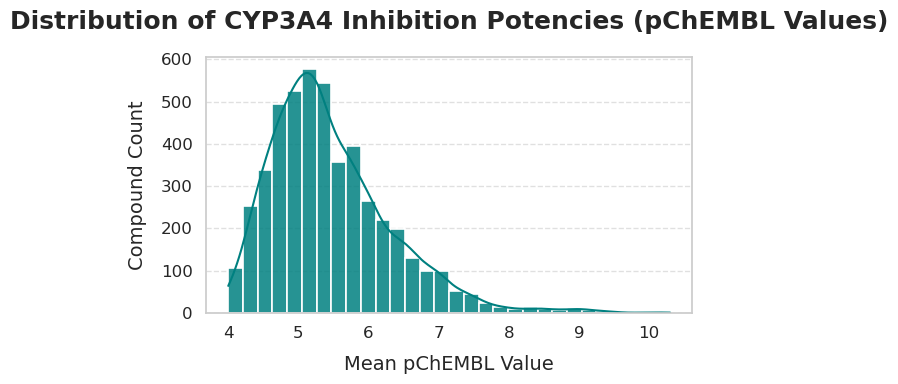

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot settings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))

# Histogram with KDE overlay
ax = sns.histplot(
    data=cyp3a4_data_agg,
    x="pchembl_value_mean",
    bins=30,
    kde=True,
    color="teal", 
    edgecolor="white",
    linewidth=1.2,
    alpha=0.85
)

# Titles and labels
ax.set_title("Distribution of CYP3A4 Inhibition Potencies (pChEMBL Values)", fontsize=18, weight="bold", pad=20)
ax.set_xlabel("Mean pChEMBL Value", fontsize=14, labelpad=10)
ax.set_ylabel("Compound Count", fontsize=14, labelpad=10)


# Make ticks bigger and easier to read
ax.tick_params(axis="both", labelsize=12)

# Subtle gridlines only on y-axis
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

Lets have a look at some of the most potent inhibitors with `mols2grid`, a handy library for visualising chemical structures in a Jupyter Notebook.



In [4]:
import mols2grid

cyp3a4_data_agg_sorted = cyp3a4_data_agg.sort_values("pchembl_value_mean", ascending=False)
mols2grid.display(cyp3a4_data_agg_sorted, smiles_col="OPENADMET_CANONICAL_SMILES", subset=["img","pchembl_value_mean"], transform={"pchembl_value_mean": lambda x: f"{x:.1f}"})

MolGridWidget()

## Final touches

Let's add some finishing touches. It's often nice to add a standard header to our dataset such that activity is standard across different datasets (`standard_value` provides this in ChEMBL).  

At OpenADMET, we often use `OPENADMET_LOGAC50` for this purpose.  

Let's also add a few columns describing our endpoint, `OPENADMET_ACTIVITY_TYPE` and target `Target`.



In [5]:
cyp3a4_data_agg_sorted["OPENADMET_ACTIVITY_TYPE"] = "IC50"
cyp3a4_data_agg_sorted["Target"] = "CYP3A4"
cyp3a4_data_agg_sorted["OPENADMET_LOGAC50"] = cyp3a4_data_agg_sorted["pchembl_value_mean"]

In [6]:
# save it to disk for use in next tutorial
cyp3a4_data_agg_sorted.to_csv("./processed_data/processed_CYP3A4_inhibition.csv")

**Now let's go on to train some models on our data!**

~ End of `01_Curate_Data_ChEMBL.ipynb` ~